## Fetch the Data and Visualize Data

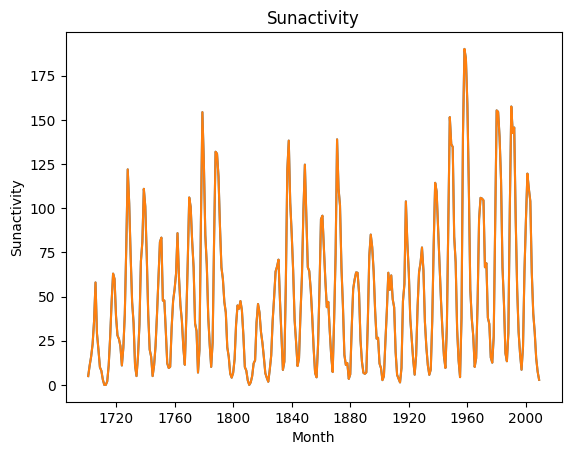

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Read the data from the CSV file
df = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
df.index = pd.date_range(start='1700', end='2009', freq='A')


df['Passengers'] = df
plt.plot(df)
plt.xlabel('Month')
plt.ylabel('Sunactivity')
plt.title('Sunactivity')
plt.show()

## Determine p,d,q,s parameters and clear trend and seasonality

ADF Statistic: -2.837781
p-value: 0.053076


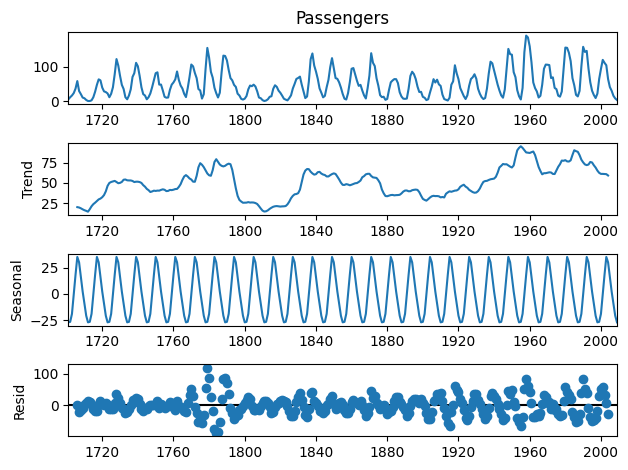

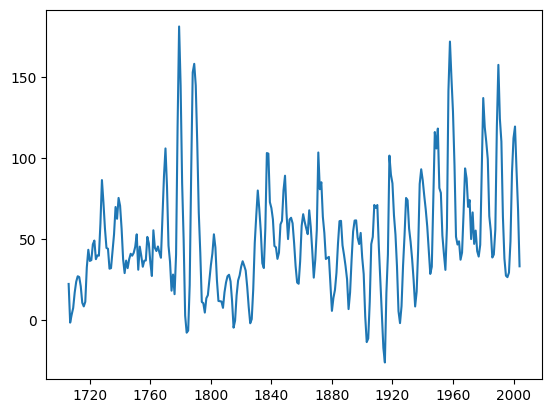

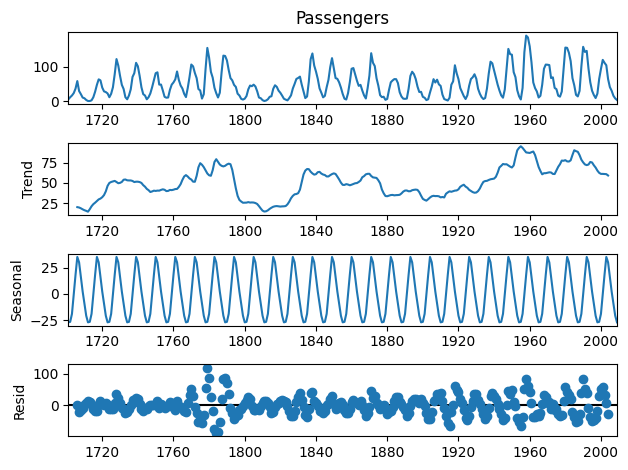

In [12]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# d = # of differencing

# First, test for stationarity

result = adfuller(df['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# s = seasonality component
s = 11
df 
# Then, decompose the series to find the seasonal component
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='additive', period=s)

train_size = int(len(df) * 0.8)
test_size = int(len(df) * 0.2)

df['trend'] = decomposition.trend

df['seasonal'] = decomposition.seasonal

df['normalized_residual'] = df['Passengers'] - df['seasonal']




df.dropna(inplace=True)  # Drop rows with NaN values
# Detrend and deseasonalize by dividing by the trend and seasonal components
df['detrended'] = df['Passengers'] / df['trend']
df['deseasonalized'] = df['detrended'] / df['seasonal']

plt.plot(df['normalized_residual'])

decomposition.plot()

In [13]:

# Normalized residual
#df['normalized_residual']=(df['residual'] - df['residual'].min()) / (df['residual'].max() - df['residual'].min())
#plt.plot(df['normalized_residual'])


In [14]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# p = AR component
p = 3

for i in range(1, p+1):
    df[f'lag_{i}'] = df['normalized_residual'].shift(i)


# q = MA component
q = 2
df['rolling_mean'] = df['normalized_residual'].rolling(window=q).mean()

df.dropna(inplace=True)  # Drop rows with NaN values

df

,SUNACTIVITY,Passengers,trend,seasonal,normalized_residual,detrended,deseasonalized,lag_1,lag_2,lag_3,rolling_mean
1708-12-31,10.0,10.0,17.181818,2.327787,7.672213,0.582011,0.250027,3.541574,-1.340870,22.490948,5.606894
1709-12-31,8.0,8.0,16.090909,-9.171540,17.171540,0.497175,-0.054208,7.672213,3.541574,-1.340870,12.421877
1710-12-31,3.0,3.0,15.272727,-20.872213,23.872213,0.196429,-0.009411,17.171540,7.672213,3.541574,20.521877
1711-12-31,0.0,0.0,14.272727,-27.227096,27.227096,0.000000,-0.000000,23.872213,17.171540,7.672213,25.549655
1712-12-31,0.0,0.0,17.363636,-26.747634,26.747634,0.000000,-0.000000,27.227096,23.872213,17.171540,26.987365
...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31,93.3,93.3,61.254545,-19.075580,112.375580,1.523152,-0.079848,91.047634,48.727096,29.472213,101.711607
2000-12-31,119.6,119.6,61.245455,0.105901,119.494099,1.952798,18.439844,112.375580,91.047634,48.727096,115.934840
2001-12-31,111.0,111.0,61.036364,18.352029,92.647971,1.818588,0.099095,119.494099,112.375580,91.047634,106.071035
2002-12-31,104.0,104.0,60.936364,35.509052,68.490948,1.706698,0.048064,92.647971,119.494099,112.375580,80.569460


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # for example

# Select features and target
X = df[['lag_1', 'lag_2', 'lag_3']]
y = df['normalized_residual']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)



## Bayesian Oprimization for Hyperparameter Tuning

In [16]:
from sklearn.model_selection import KFold, GridSearchCV
from skopt.plots import plot_objective, plot_histogram
import skopt
from sklearn.linear_model import LinearRegression
import numpy as np

# Decleartions for deprecated functions in numpy
np.float = float    
np.int = int    
np.object = object    
np.bool = bool    

# Define hyperparameters for bayesian optimization
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
    }


kFold = KFold(n_splits=5, shuffle=True, random_state=42)

model = LinearRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= kFold, n_jobs=-1, 
                             scoring='neg_mean_absolute_percentage_error')

grid_search.fit(X_train, y_train)

# Print the cross validation results
cv_results = grid_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df['fit_intercept'] = cv_results_df['params'].apply(lambda x: x['fit_intercept'])
cv_results_df['copy_X'] = cv_results_df['params'].apply(lambda x: x['copy_X'])


print(cv_results_df[['mean_test_score', 'fit_intercept', 'copy_X']])

# plot_objective creates pairwise dependence plot of the objective function.
# plot_objective(bayes_search.optimizer_results_[0],
#                    dimensions=["C", "gamma", "epsilon"],
#                    n_minimum_search=int(1e8))

# Print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

best_model = grid_search.best_estimator_

   mean_test_score  fit_intercept  copy_X
0        -0.538016           True    True
1        -1.007314          False    True
2        -0.538016           True   False
3        -1.007314          False   False
Best hyperparameters: {'copy_X': True, 'fit_intercept': True}


60


,normalized_residual
1944-12-31,28.675580
1945-12-31,33.094099
1946-12-31,74.247971
1947-12-31,116.090948
1948-12-31,105.959130
1949-12-31,118.241574
1950-12-31,81.572213
1951-12-31,78.571540
1952-12-31,52.372213
1953-12-31,41.127096


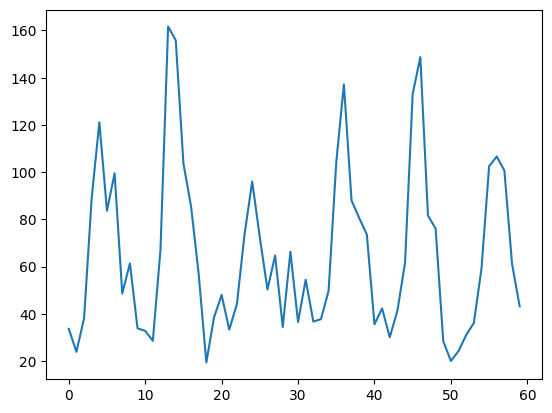

In [17]:

best_model.fit(X_train, y_train)

# Predict residuals
residuals_predicted = best_model.predict(X_test)
plt.plot(residuals_predicted)
print(len(residuals_predicted))
test_df = pd.DataFrame(y_test)
test_df

In [18]:
df['trend_train'] = df['trend'][:train_size]
df['trend_test'] = df['trend'][train_size:]
df['seasonal_train'] = df['seasonal'][:train_size]
df['seasonal_test'] = df['seasonal'][train_size:]
print(df['seasonal'][train_size:].shape)
print(df['seasonal_test'].shape)

(49,)
(296,)


(60,)
(296,)
(296,)
DatetimeIndex(['1944-12-31', '1945-12-31', '1946-12-31', '1947-12-31',
               '1948-12-31', '1949-12-31', '1950-12-31', '1951-12-31',
               '1952-12-31', '1953-12-31', '1954-12-31', '1955-12-31',
               '1956-12-31', '1957-12-31', '1958-12-31', '1959-12-31',
               '1960-12-31', '1961-12-31', '1962-12-31', '1963-12-31',
               '1964-12-31', '1965-12-31', '1966-12-31', '1967-12-31',
               '1968-12-31', '1969-12-31', '1970-12-31', '1971-12-31',
               '1972-12-31', '1973-12-31', '1974-12-31', '1975-12-31',
               '1976-12-31', '1977-12-31', '1978-12-31', '1979-12-31',
               '1980-12-31', '1981-12-31', '1982-12-31', '1983-12-31',
               '1984-12-31', '1985-12-31', '1986-12-31', '1987-12-31',
               '1988-12-31', '1989-12-31', '1990-12-31', '1991-12-31',
               '1992-12-31', '1993-12-31', '1994-12-31', '1995-12-31',
               '1996-12-31', '1997-12-31', '1998-12-31', 

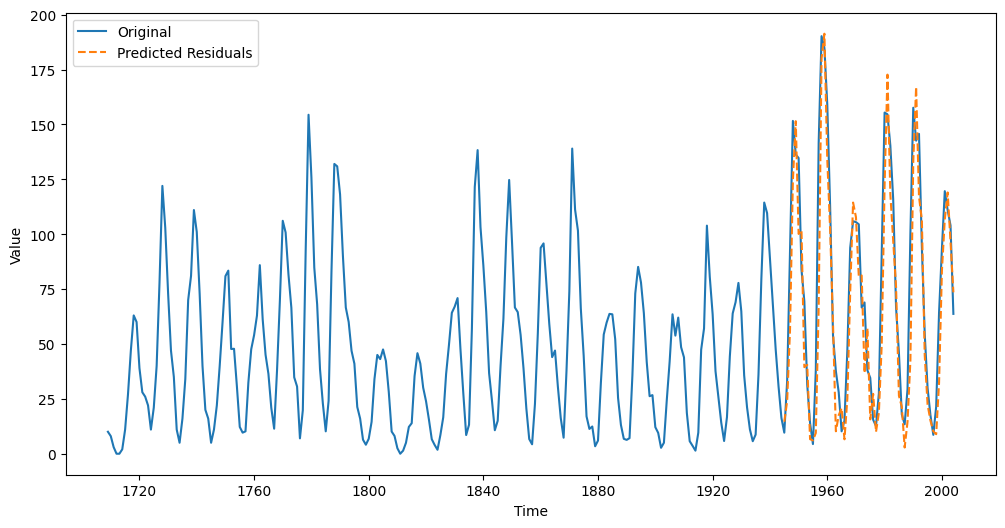

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for the predicted residuals
residuals_predicted_df = pd.DataFrame(residuals_predicted, index=X_test.index, columns=['predicted_residuals'])

# Denormalize data
#residuals_predicted_df = (residuals_predicted_df - residuals_predicted_df.min()) / (residuals_predicted_df.max() - residuals_predicted_df.min())

print(residuals_predicted_df['predicted_residuals'].shape)
print(df['seasonal_test'].shape)
print(df['trend_test'].shape)
# Add trend and seasonality back to the perdicted residual
residuals_predicted_df['reconstructed'] =  residuals_predicted_df['predicted_residuals'] + df['seasonal']


# Plot
fig, ax = plt.subplots(figsize=(12,6))

# Plot the latter part of the original time series
ax.plot(df.loc[df.index, 'Passengers'], label='Original')

# Plot the predicted residuals
ax.plot(residuals_predicted_df['reconstructed'], label='Predicted Residuals', linestyle='--')

print(residuals_predicted_df['reconstructed'].index)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import math

# Assuming 'Passengers' is your original data and 'reconstructed' is your predicted data
mse = mean_squared_error(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])
rmse = math.sqrt(mse)
nrmse = rmse / (df.loc[X_test.index, 'Passengers'].max() - df.loc[X_test.index, 'Passengers'].min())
r2e = r2_score(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])
mape = mean_absolute_percentage_error(df.loc[X_test.index, 'Passengers'], residuals_predicted_df['reconstructed'])

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Normalized Root Mean Squared Error:", nrmse)
print("R Squared Error: ", r2e)
print("MAPE", mape)

Mean Squared Error:  485.33911217451055
Root Mean Squared Error:  22.03041334552102
Normalized Root Mean Squared Error: 0.11857057774769118
R Squared Error:  0.8207011138366087
MAPE 0.3123153480873525
